In [62]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import seaborn as sns

repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(repo_root)


from src.utils import MNIST, total_variation_loss_model, evaluate_loss_acc
from src.model import CNN, MLP
from src.utils import MNIST, evaluate_loss_acc, LOGGER

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [63]:
DEVICE = "mps"

# Папка с чекпоинтами
CHECKPOINT_DIR = f"{repo_root}/data/checkpoints/exp5"

In [64]:
ticks = 1
num_epochs = 1
batch_sizes = [1, 4, 8, 16, 32, 64]

all_noise_norms = {batch_size: [] for batch_size in batch_sizes}

for batch_size in batch_sizes:
    LOGGER.reset()
    LOGGER.load(f'{CHECKPOINT_DIR}/MNIST_CNN_{ticks}tick_steps_{num_epochs}epochs_{batch_size}batch_size')
    
    full_grads = {}
    stochastic_grads = {}
    grad_noise_norms = {}

    for name, values in LOGGER.dict.items():

        values = np.array([ value.cpu().numpy() for value in values])
        # print(name , values.shape)
        if 'full_' in name:
            full_grads[name.split('full_')[-1]] = values
        elif 'stochastic_' in name:
            stochastic_grads[name.split('stochastic_')[-1]] = values

    for key in full_grads.keys():
        grad_noise_norms[key] = np.mean((full_grads[key] - stochastic_grads[key])**2, axis=tuple(range(1, full_grads[key].ndim )))
        # print(grad_noise_norms[key].shape)
    all_noise_norms[batch_size] = grad_noise_norms

(100, 6, 1, 5, 5) (100,)


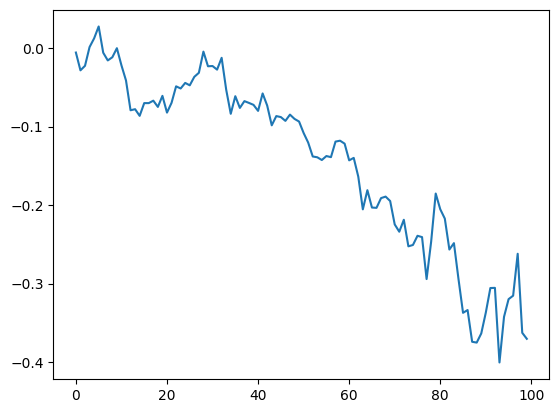

(100, 6, 1, 5, 5) (100,)


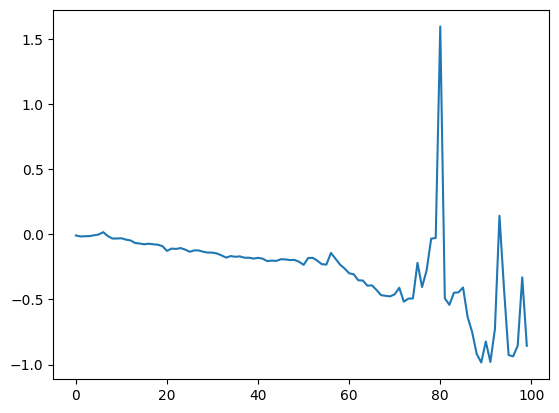

(100, 6, 1, 5, 5) (100,)


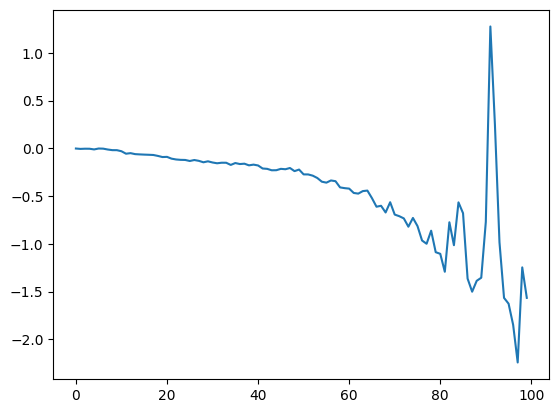

(100, 6, 1, 5, 5) (100,)


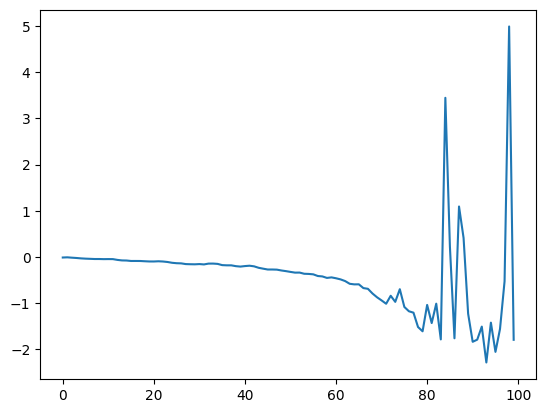

(100, 6, 1, 5, 5) (100,)


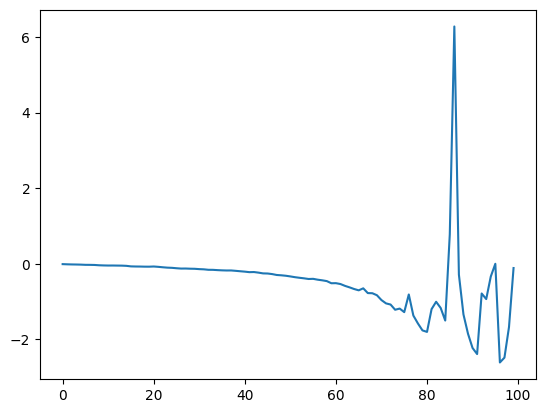

(100, 6, 1, 5, 5) (100,)


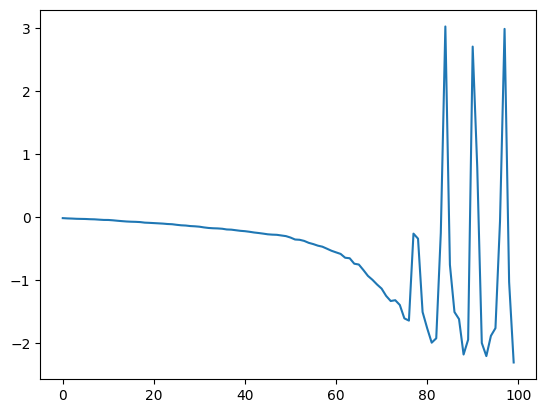

In [65]:
vals = []
for batch_size in batch_sizes:
    LOGGER.reset()
    LOGGER.load(f'{CHECKPOINT_DIR}/MNIST_CNN_{ticks}tick_steps_{num_epochs}epochs_{batch_size}batch_size')

    for k in LOGGER.dict.keys():
        val = np.array([ v.cpu().numpy() for v in LOGGER.dict[k]]) 
        val_r = val.mean(axis=tuple(range(1, val.ndim )) )
        vals.append(val_r)
        print(val.shape, val_r.shape )
        plt.plot(val_r)
        plt.show()
        break

layer1.0.weight
layer1.0.bias
layer2.0.weight
layer2.0.bias
fc.weight
fc.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


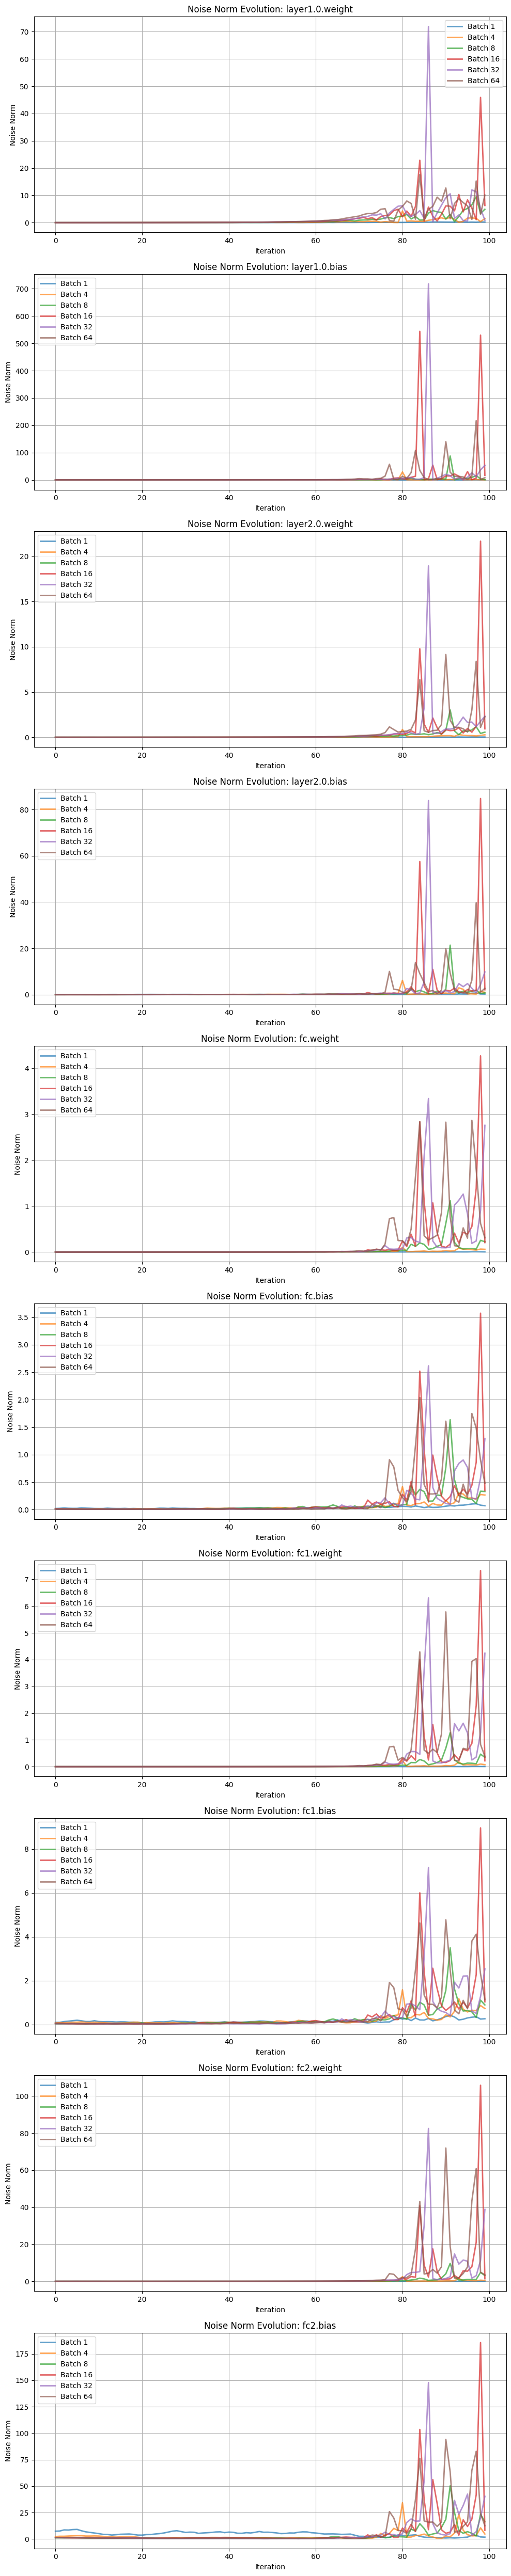

In [ ]:
# Получаем список batch_size из ключей словаря
batch_sizes = sorted(all_noise_norms.keys())

# Берем любой dict (по первому batch_size) и извлекаем ключи слоев
layer_keys = list(next(iter(all_noise_norms.values())).keys())

# Создаем subplots для всех слоев
fig, axes = plt.subplots(len(layer_keys), 1, figsize=(10, 5 * len(layer_keys)))

# Если один ключ — делаем axes одномерным
if len(layer_keys) == 1:
    axes = [axes]

# Итерируемся по слоям (ключам)
for i, key in enumerate(layer_keys):
    ax = axes[i]
    
    # print(key)

    # Для каждого batch_size строим линию
    for batch_size in batch_sizes:

        noise_norm_evolution = all_noise_norms[batch_size][key]  # Достаем список норм по итерациям
        
        # print(noise_norm_evolution.shape , sum(noise_norm_evolution))
        ax.plot(noise_norm_evolution, label=f'Batch {batch_size}', alpha=0.7, linewidth=2)

    ax.set_title(f'Noise Norm Evolution: {key}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Noise Norm')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


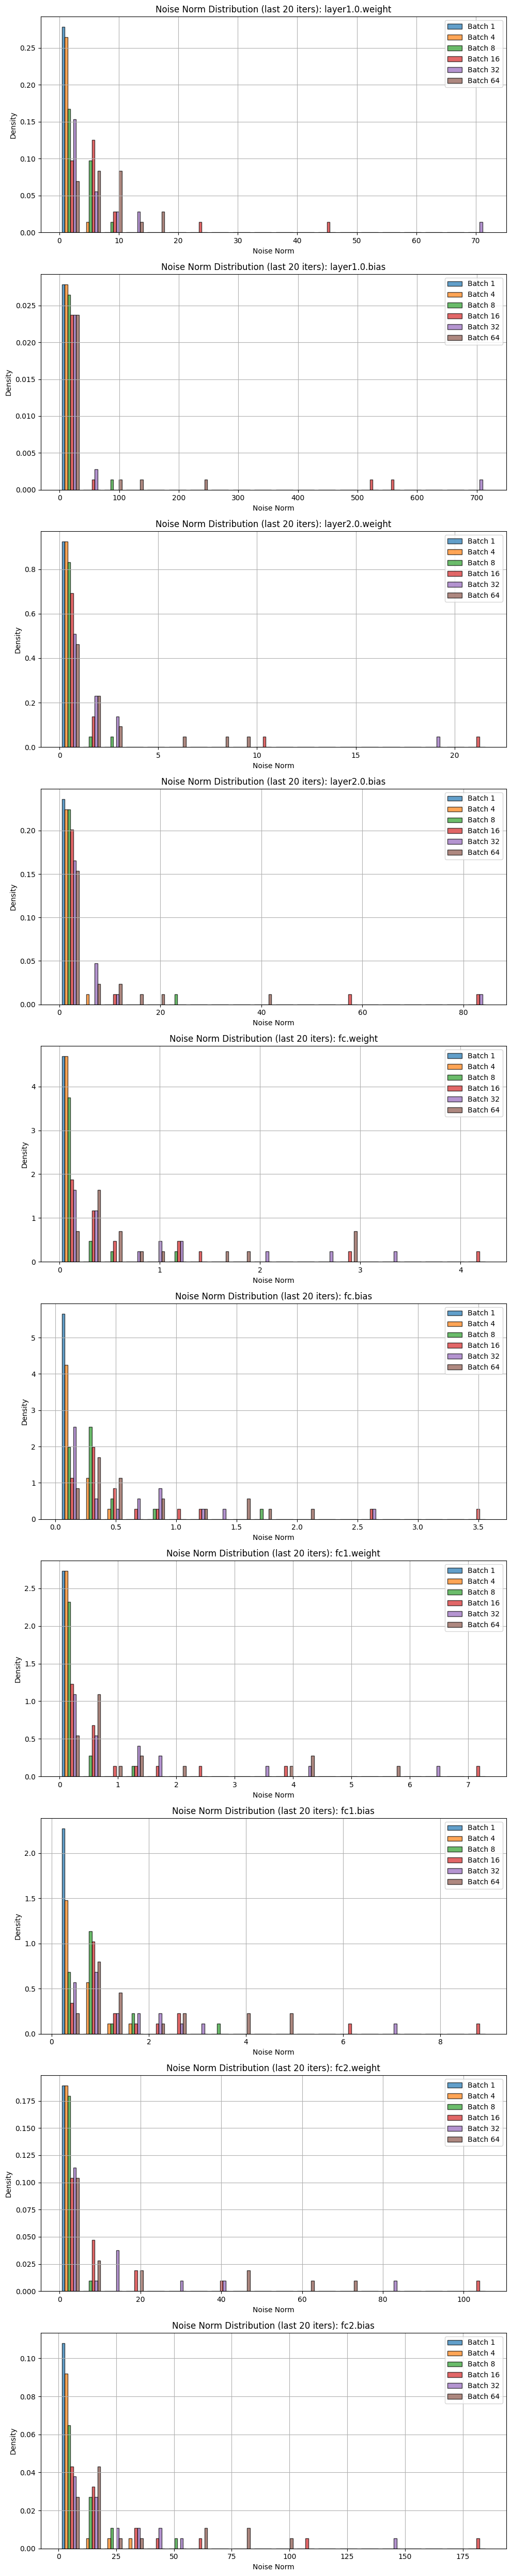

In [68]:

num_last_iters = 20

# Создаем subplots для каждого слоя
fig, axes = plt.subplots(len(layer_keys), 1, figsize=(10, 5 * len(layer_keys)))

# Если один ключ – делаем axes одномерным
if len(layer_keys) == 1:
    axes = [axes]

# Итерируемся по слоям (ключам)
for i, key in enumerate(layer_keys):
    ax = axes[i]

    # Собираем данные по последним 20 итерациям для всех batch_size
    data = []
    labels = []

    for batch_size in batch_sizes:
        noise_norm_evolution = all_noise_norms[batch_size][key]  # Достаем список норм по итерациям
        last_values = noise_norm_evolution[-num_last_iters:]  # Берем последние 20 итераций
        
        data.append(last_values)
        labels.append(f'Batch {batch_size}')
    
    # Создаем гистограмму
    ax.hist(data, bins=20, label=labels, alpha=0.7, edgecolor='black', density=True)

    ax.set_title(f'Noise Norm Distribution (last {num_last_iters} iters): {key}')
    ax.set_xlabel('Noise Norm')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
